<a href="https://colab.research.google.com/github/ayuksekdag/winacademy_python_dna/blob/main/final_assignment/final_co2Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment / Questions

- What is the biggest predictor of a large CO2 output per capita of a country?
- Which countries are making the biggest strides in decreasing CO2 output?
- Which non-fossil fuel energy technology will have the best price in the future?

Biggest predictor of CO2 output

To determine this you may want to consider things like GDP per capita, diets, number of cars per capita, various energy source, mobility and other factors.

Your answer can also be a specific combination of certain factors. Anyway, remember to include the explanations in your report.


Biggest strides in decreasing CO2 output

You'll need to find the relative CO2 output for each country to be able to calculate this. But countries can have growing and shrinking populations too, so it's probably a good idea to take this into account as well.


Biggest strides in decreasing CO2 output

You'll need to find the relative CO2 output for each country to be able to calculate this. But countries can have growing and shrinking populations too, so it's probably a good idea to take this into account as well.

In [99]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Scope of sources

- source 1: https://ourworldindata.org/co2-emissions#per-capita-co2-emissions
  - filename: co2-per-capita-marimekko.csv
  - alias: co2_cap

- source 2: https://ourworldindata.org/grapher/per-capita-energy-use
  - filename: gdp-per-capita-worldbank
  - alias: gdp_cap

- source 3: https://ourworldindata.org/grapher/levelized-cost-of-energy
  - filename:levelized-cost-of-energy.csv
  - alias: cost_engy

- source 4: https://ourworldindata.org/population-growth
  - filename:population-and-demography.csv
  - alias: pop



In [100]:
co2_cap = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/co2-per-capita-marimekko.csv')
gdp_cap = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/gdp-per-capita-worldbank.csv')
cost_engy = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/levelized-cost-of-energy.csv')
pop = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/population-and-demography.csv')

In [101]:
# co2_cap.head(3)
# gdp_cap.head(3)
#cost_engy.head(3)
#pop.head()

# Data preparation
Renaming columns

Data conversions
  - year column to date

Cleaning of data.
  - Goal: All datasets must have same countries and same selection of years
  - How: To achieve this I take a inner join (intersection) of all datasets on country and year of the measure.


In [102]:
#rename long column names with spaces and special characters
co2_cap.rename(columns={'Annual CO₂ emissions (per capita)': 'c02'}, inplace=True)
gdp_cap.rename(columns={'GDP per capita, PPP (constant 2017 international $)': 'gdp'}, inplace=True)
pop = pop.rename(columns={'Country name': 'Entity'})
# print(gdp_cap.dtypes)
# print(co2_cap.dtypes)

In [103]:
#change datatype year to datetime
co2_cap['Year'] = pd.to_datetime(co2_cap['Year'], format='%Y')
gdp_cap['Year'] = pd.to_datetime(gdp_cap['Year'], format='%Y')
pop['Year'] = pd.to_datetime(pop['Year'], format='%Y')

# print(co2_cap.dtypes)
# print(gdp_cap.dtypes)

# print(f' \n grootte co2_cap  {co2_cap.shape}')
# print(f' \n grootte gdp_cap {gdp_cap.shape}')


In [108]:
# remove columns
# the columns that stay
pop.Entity.unique()
#pop = pop[['Entity','Year','Population']]




array(['Afghanistan', 'Africa (UN)', 'Albania', 'Algeria',
       'American Samoa', 'Andorra', 'Angola', 'Anguilla',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia (UN)', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bonaire Sint Eustatius and Saba', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial

In [95]:
# INTERSECTION INNER JOIN TO CREATE
# 1 DATASET BASED ON COUNTRY AND YEAR.


merged_co2_gdp = (
    pd.merge(co2_cap,gdp_cap, how="inner", on=['Year','Code'], suffixes=('', '_y'))
    .drop(['Entity_y','Continent'], axis=1)
)

# # print(merge_co2_gdp.dtypes, '\n')

merged_co2_gdp_pop = (
    pd.merge(merged_co2_gdp ,pop, how="inner", on=['Year','Entity'], suffixes=('', '_y'))
    # .drop(['Code'], axis=1)
)

# print(f'final dataset struct merged_co2_gdp_engy \n\n{merged_co2_gdp_engy.dtypes}')


merged_co2_gdp_pop

,Entity,Code,Year,c02,gdp,Population,Population of children under the age of 1,Population of children under the age of 5,Population of children under the age of 15,Population under the age of 25,...,Population aged 15 to 19 years,Population aged 20 to 29 years,Population aged 30 to 39 years,Population aged 40 to 49 years,Population aged 50 to 59 years,Population aged 60 to 69 years,Population aged 70 to 79 years,Population aged 80 to 89 years,Population aged 90 to 99 years,Population older than 100 years
0,Afghanistan,AFG,2002-01-01,0.063856,1280.4631,21000258,941149.0,4280854,10488288,14365919,...,2120744,3227457,2131886,1346252,899545,524785,218247,41164,1879,11.0
1,Afghanistan,AFG,2003-01-01,0.068871,1292.3335,22645136,999679.0,4574403,11313832,15499313,...,2305766,3461165,2307019,1451498,958962,563715,236002,45091,2075,11.0
2,Afghanistan,AFG,2004-01-01,0.052529,1260.0605,23553554,1020639.0,4705370,11758413,16126358,...,2425646,3581266,2409322,1511624,986258,585104,246037,47662,2212,11.0
3,Afghanistan,AFG,2005-01-01,0.077403,1352.3207,24411196,1032348.0,4795376,12111730,16680276,...,2547608,3727055,2523660,1575352,1011252,605784,255379,50590,2739,46.0
4,Afghanistan,AFG,2006-01-01,0.084869,1366.9932,25442946,1058386.0,4912481,12525732,17340328,...,2687976,3914320,2660941,1654321,1043980,631641,266723,53964,3254,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7514,Zimbabwe,ZWE,2017-01-01,0.650533,2331.7808,14751101,464521.0,2287404,6217928,9224369,...,1690993,2422873,2021973,1088878,570769,467775,200927,59789,8974,222.0
7515,Zimbabwe,ZWE,2018-01-01,0.783639,2399.6216,15052191,466524.0,2283576,6291632,9385132,...,1732035,2474502,2058928,1155537,585529,476214,208587,59700,9299,228.0
7516,Zimbabwe,ZWE,2019-01-01,0.723861,2203.3967,15354606,468844.0,2281740,6367398,9543409,...,1759205,2546398,2085636,1220993,606266,479827,218763,60339,9546,235.0
7517,Zimbabwe,ZWE,2020-01-01,0.676970,1990.3195,15669663,470340.0,2287105,6449021,9709135,...,1776240,2640150,2101852,1291333,631541,476507,231604,61546,9629,240.0


### Question / Answer 1:
- Q: What is the biggest predictor of a large CO2 output per capita of a country?
- A: There is a direct correlation between GDP and Co2 emmission. In general the higher GDP per capita the more energy consumption and c02 emmision it creates


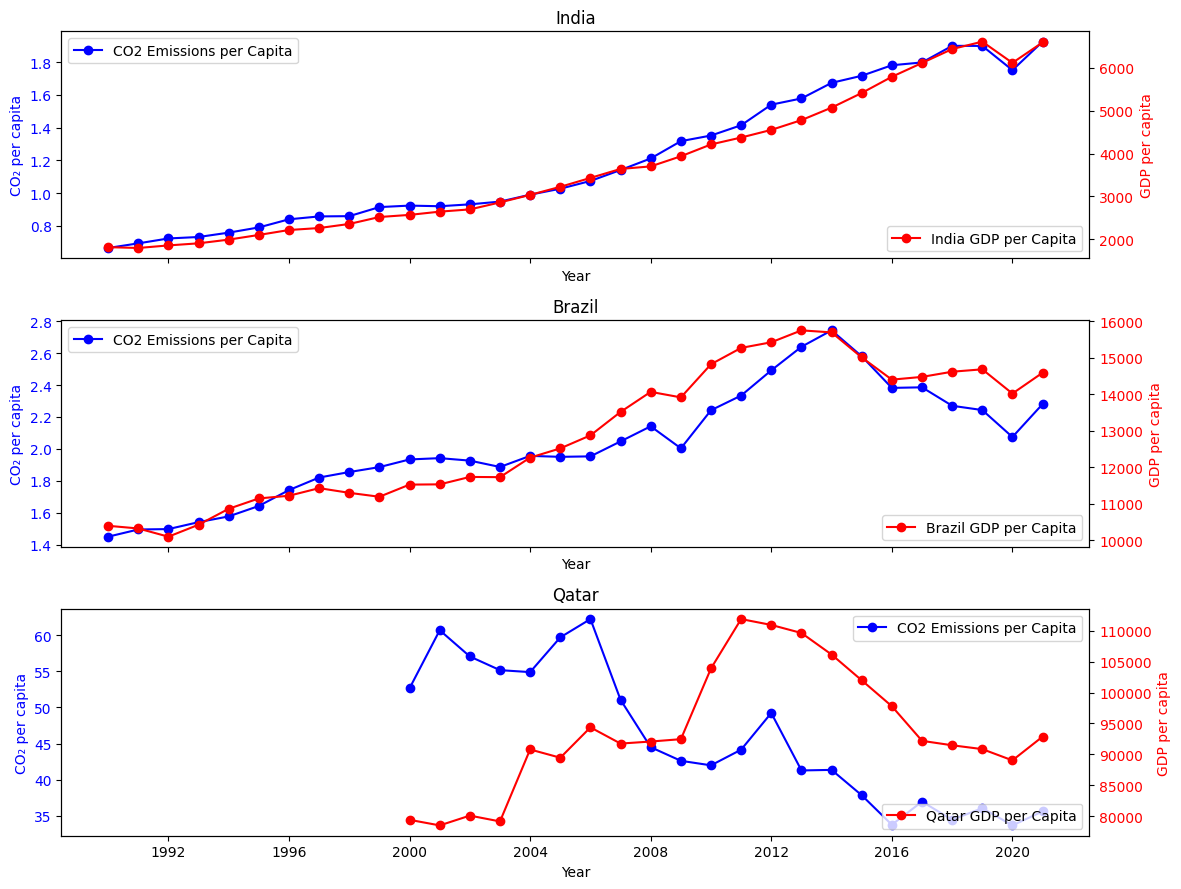

In [96]:
#take 3 countries to examine
# 3 Bricks: China & India and Brazil
countries_to_plot = {"Qatar", "India", "Brazil"}

# Create subplots
fig, ax = plt.subplots(len(countries_to_plot), 1, figsize=(12, 9), sharex=True)

c02_color='blue'
gdp_color='red'
pop_color='green'

#loop for every county
for i, country in enumerate(countries_to_plot):

  df = merged_co2_gdp_pop[merged_co2_gdp_pop["Entity"] == country]

  # Plot the first measure c02  on the left y-axis
  # x-axis is year (shared)
  ax[i].set_title(f"{country}")
  ax[i].plot(df["Year"], df["c02"], label="CO2 Emissions per Capita", marker='o', color=c02_color)

  ax[i].set_ylabel('CO₂ per capita', color=c02_color)
  ax[i].tick_params(axis='y', labelcolor=c02_color)
  ax[i].set_xlabel("Year")
  ax[i].legend()


  # Create a second y-axis for measure gdp on the right side
  # with a shared x-axis using year
  ax2 = ax[i].twinx()

  # Plot the second dataset on the right y-axis
  ax2.plot(df["Year"], df["gdp"], label=f"{country} GDP per Capita", marker='o', color=gdp_color)
  ax2.set_ylabel('GDP per capita', color=gdp_color)
  ax2.tick_params(axis='y', labelcolor=gdp_color)
  ax2.legend(loc='lower right')


#plot it
plt.tight_layout()
plt.show()



### Question / Answer 2:
- Q: Which countries are making the biggest strides in decreasing CO2 output?
- A: We calculate the relative C02 emission using formula
  population by Entity of that year divided by  latest population)
  2. Range (highest C02 emission by Entity - latest Year C02 emmission).


The top 10 is listed in a stacked bar chart

In [97]:
df = pop.copy()
#pop.set_index('Entity','Year', inplace = True)

df['relative_change_pop'] = pop['Population'].pct_change()

df.sort_values('relative_change_pop', ascending=False)

,Entity,Year,Population,Population of children under the age of 1,Population of children under the age of 5,Population of children under the age of 15,Population under the age of 25,Population aged 15 to 64 years,Population older than 15 years,Population older than 18 years,...,Population aged 20 to 29 years,Population aged 30 to 39 years,Population aged 40 to 49 years,Population aged 50 to 59 years,Population aged 60 to 69 years,Population aged 70 to 79 years,Population aged 80 to 89 years,Population aged 90 to 99 years,Population older than 100 years,relative_change_pop
11088,More developed regions,1950-01-01,806252900,18306018.0,81664090,221791400,360235780,522666750,584452540,543885250,...,133888540,108080540,104772200,77825460,54891460,29052712,7541976,608313,8962.0,181669.324470
864,Asia (UN),1950-01-01,1379048300,49825476.0,204085740,510936200,770154430,810616960,868109000,783279940,...,227706660,176487470,138436110,95404190,59557764,26051938,6375938,429656,3170.0,12942.584281
17424,Upper-middle-income countries,1950-01-01,900338500,31869686.0,128151600,319113380,488662180,538853250,581220860,527037400,...,150103420,114933280,95034460,65886950,43212676,18640780,4885110,381442,4276.0,8993.390609
12096,North Korea,1950-01-01,11103386,380009.0,1750476,4935266,7184819,5866335,6168115,5375791,...,1798941,1156538,816320,624061,374223,123573,17334,698,5.0,5672.677057
18000,World,1950-01-01,2499322000,81711670.0,341876800,867688260,1324977300,1503426300,1631619500,1486728200,...,413760960,322364670,269392260,189938430,123919624,59093256,14847612,1129242,14469.0,4417.964267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12672,Palau,1950-01-01,7451,299.0,1346,3286,4388,3525,4165,3769,...,963,859,535,389,307,321,160,11,0.0,-0.999968
12024,Niue,1950-01-01,4509,184.0,680,1753,2662,2540,2756,2437,...,701,461,411,321,228,95,26,0,0.0,-0.999979
12312,Northern Mariana Islands,1950-01-01,7083,303.0,1216,3046,4253,3828,4037,3634,...,1153,914,627,388,206,90,22,0,0.0,-0.999981
5112,Falkland Islands,1950-01-01,2213,34.0,330,933,1289,1097,1280,1154,...,314,260,165,112,99,97,32,4,0.0,-0.999997


In [98]:

pop.head(4)


#get the max c02 by Entity
entity_max_c02= (merged_co2_gdp_engy
 .groupby('Entity')['c02']
 .agg(['max'])
)

#rename columm
entity_max_c02 = entity_max_c02.rename(columns={'max': 'max_c02'})

#get the max current data driven
entity_max_year = (merged_co2_gdp_engy
 .groupby('Entity')['Year']
 .agg({'max'}).reset_index()
)
#rename column
entity_max_year = entity_max_year.rename(columns={'max': 'Year'})

#merge the above sets on Entity
entity_c02_of_max_year = (
    pd.merge(
        entity_max_year, entity_max_c02, how="inner", on=['Entity'],suffixes=('', '_y'),sort=False
        )
    #  .drop(['Entity_y',"Year_y"], axis=1)

)


#merge again now to get the current c02 value on same row
entity_max_c02_and_max_year_c02=(
        pd.merge(
            entity_c02_of_max_year, co2_cap, how="inner", on=['Entity','Year'],suffixes=('', '_y'),sort=False
        )
        .drop(['Code',"Continent"], axis=1)
)

# derived column c02_difference
entity_max_c02_and_max_year_c02['c02_difference'] = entity_max_c02_and_max_year_c02['max_c02'] - entity_max_c02_and_max_year_c02['c02']


#prep for plot
entity_max_c02_and_max_year_c02.drop(['Year'], axis=1, inplace=True)
entity_max_c02_and_max_year_c02.set_index('Entity', inplace=True)
entity_max_c02_and_max_year_c02 = entity_max_c02_and_max_year_c02.rename(columns={'c02': 'current c02', 'max_c02': 'highest c02', 'c02_difference': 'c02 reduction'})


#plot it
(entity_max_c02_and_max_year_c02
   .sort_values('c02 reduction', ascending=False ).head(10)
   .plot(kind='bar', stacked=True
         , ylabel='c02'
         , title='Countries making biggest decrease of C02'
   )
)

NameError: ignored

### Question / Answer 3:
- Q: Which non-fossil fuel energy technology will have the best price in the future?
- A: take the all on rows on World level. Plot it using x-axis Year
Onshore seems to be lowest and going lower. Solar is following up.

In [ ]:
cost_engy.dtypes

In [ ]:
cost_engy.rename(columns={'Bioenergy levelized cost of energy': 'bioenergy',
                        'Geothermal levelized cost of energy':'geothermal',
                        'Offshore wind levelized cost of energy':'offshore_wind',
                        'Solar photovoltaic levelized cost of energy':'solar',
                        'Concentrated solar power levelized cost of energy':'concentrated_solar',
                        'Hydropower levelized cost of energy':'hydro',
                        'Onshore wind levelized cost of energy':'onshore_wind'
                        }, inplace=True)

cost_engy.dtypes

In [ ]:
df = cost_engy[cost_engy.Entity.isin(['World'])].copy()

#drop the unnecessary columns for the plot dataset
df.drop(['Entity','Code'], axis=1, inplace=True)

# set the x-axis ready for plot
df.set_index('Year', inplace=True)

#df.dtypes


In [ ]:
(
    df.plot(kind='line',
          ylabel='price $/kwh',
            title='Non fossil fuel energy costs')
)